## first pass at correlating error and UQ

In [1]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.io import read
from ase import units
from pathlib import Path
import shutil
from mace.calculators import mace_mp
import matplotlib.pyplot as plt
import numpy as np

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.loa

Configuration

In [2]:
method: str = 'mace-medium'
temperature = 298
initial_geometry = '../0_setup/final-geometries/packmol-CH4-in-H2O=32-seed=1-mace-medium.vasp'
steps: int = 2048

In [3]:
name = f'{Path(initial_geometry).name[:-5]}-nvt={temperature}'
run_dir = Path('md') / name

In [4]:
run_dir.mkdir(exist_ok=True, parents=True)

In [5]:
run_dir

PosixPath('md/packmol-CH4-in-H2O=32-seed=1-mace-medium-nvt=298')

## Perform the Dynamics
Run a set number of MD steps

In [6]:
traj_file = run_dir / 'md.traj'
if traj_file.is_file() and traj_file.stat().st_size > 0:
    traj = read(str(traj_file), slice(None))
    start = len(traj)
    atoms = traj[-1]
    print('Loaded last structure')
else:
    atoms = read(initial_geometry)
    start = 0
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)

Loaded last structure


Relax it

In [7]:
atoms.calc = mace_mp(method.split('-')[-1])

Using Materials Project MACE for MACECalculator with /home/mike/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loca

Default dtype float32 does not match model dtype float64, converting models to float32.


In [8]:
dyn = Langevin(atoms,
          friction=0.05/units.fs,
          timestep=0.5 * units.fs,
          temperature_K=temperature,
          logfile=str(run_dir / 'md.log'),
          trajectory=str(traj_file),
          append_trajectory=True)

In [9]:
%%time
dyn.run(steps - start)

CPU times: user 470 ms, sys: 289 ms, total: 759 ms
Wall time: 576 ms


True

## look at dynamics results

In [10]:
from ase.io import read

In [11]:
traj = read(traj_file, index=':')

In [12]:
T = [a.get_temperature() for a in traj]

Text(0.5, 0, 'timestep (0.5fs)')

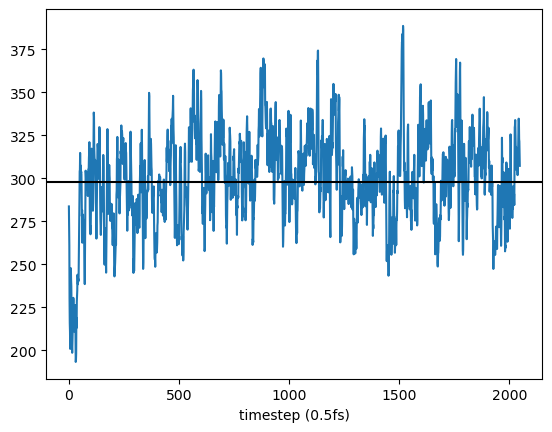

In [13]:
plt.plot(T)
plt.axhline(temperature, color='k')
plt.xlabel('timestep (0.5fs)')

In [14]:
np.mean(T)

299.8233173848139

In [15]:
temperature

298

I'd say this is okay for now.

## look at error with mace MP-small

In [16]:
F_med = [a.get_forces() for a in traj]

In [17]:
small = mace_mp('small')

Using Materials Project MACE for MACECalculator with /home/mike/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loca

In [18]:
from tqdm import tqdm

In [19]:
F_sm = []
for a in tqdm(traj):
    a.calc = small
    F_sm.append(a.get_forces())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [02:08<00:00, 16.00it/s]


In [20]:
np.linalg.norm(F_sm[0] - F_med[0], axis=1)

array([0.04927279, 0.03307442, 0.02284243, 0.0393975 , 0.02109378,
       0.05712046, 0.02950374, 0.0436942 , 0.04710906, 0.09034049,
       0.06150988, 0.0877877 , 0.01525922, 0.04532487, 0.02486785,
       0.13308951, 0.09207342, 0.08389984, 0.0316043 , 0.0539654 ,
       0.05226195, 0.02718896, 0.15620624, 0.07220657, 0.06456016,
       0.14600805, 0.03450434, 0.04008311, 0.02525914, 0.04396325,
       0.02347789, 0.02356234, 0.03930777, 0.02344608, 0.06394911,
       0.09868025, 0.03901123, 0.03679123, 0.03575158, 0.10332602,
       0.06232373, 0.05844771, 0.04079265, 0.04466393, 0.06141367,
       0.04513815, 0.01365869, 0.05218338, 0.02210859, 0.06178138,
       0.04250146, 0.08770939, 0.06435915, 0.01047946, 0.07501471,
       0.05574366, 0.08001656, 0.08245408, 0.03934317, 0.06065193,
       0.05138597, 0.04478557, 0.12820726, 0.11596179, 0.1084382 ,
       0.0199472 , 0.03818998, 0.04164041, 0.06503427, 0.06957974,
       0.03789444, 0.08563609, 0.02960181, 0.03897486, 0.05910

In [21]:
F_sm = np.asarray(F_sm)

In [22]:
F_med = np.asarray(F_med)

In [23]:
F_sm.shape

(2048, 101, 3)

In [24]:
error_norms = np.linalg.norm(F_sm - F_med, axis=-1)

In [25]:
F_err_max = error_norms.max(-1)

In [26]:
F_err_mean = error_norms.mean(-1)

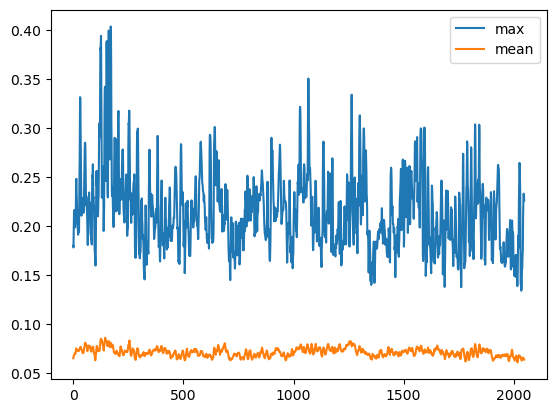

In [27]:
plt.plot(F_err_max, label='max')
plt.plot(F_err_mean, label='mean')
plt.legend()

## building the regressor

We want to predict error from the mace descriptors

In [28]:
desc = small.get_descriptors(a)

In [29]:
desc.shape

(101, 256)

a is an MD frame, should we predict error for the whole frame or atom-wise error?

I fear that 101*256 ~= 25,000 is too big of a feature space for a simple regressor. lets try per-atom

In [30]:
X = [small.get_descriptors(a) for a in traj]

In [31]:
error_norms.shape

(2048, 101)

In [32]:
X = np.asarray(X)

In [33]:
X.shape

(2048, 101, 256)

In [34]:
X = X.reshape(-1, 256)
y = error_norms.ravel()

In [35]:
X.shape, y.shape

((206848, 256), (206848,))

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100_000)

In [71]:
model = KNeighborsRegressor()

In [72]:
model.fit(X_train, y_train)

KNeighborsRegressor()

In [73]:
y_hat = model.predict(X_test)

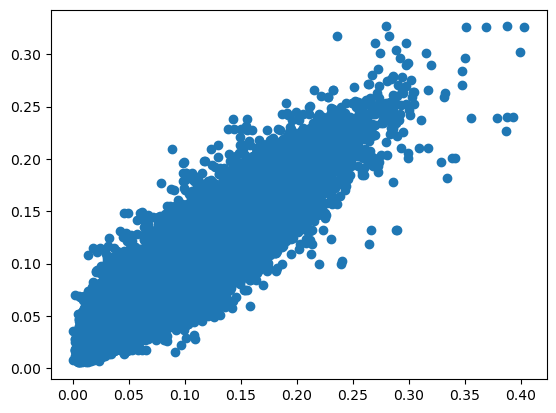

In [74]:
plt.scatter(y_test, y_hat)

In [75]:
from minervachem.plotting import parity_plot

In [76]:
y_hat_train = model.predict(X_train)

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'test')

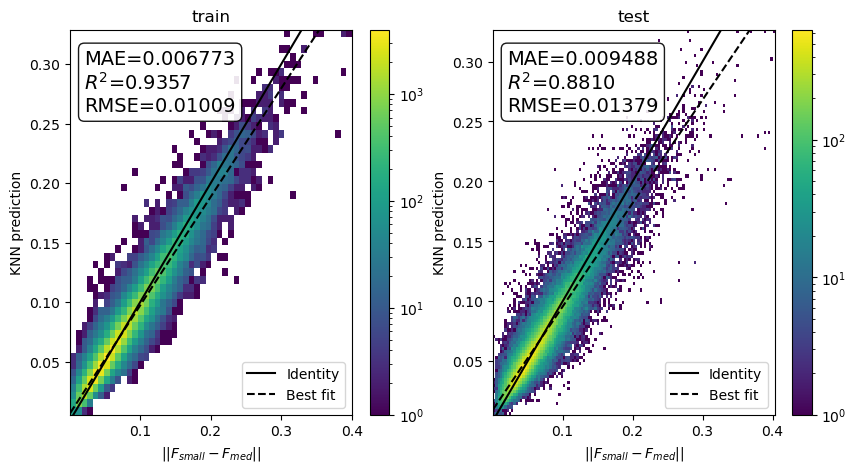

In [77]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
parity_plot(y_train, y_hat_train, identity=True, ax=ax[0])
plt.sca(ax[0])
plt.xlabel('$||F_{small} - F_{med}||$')
plt.ylabel('KNN prediction')
plt.title('train')

parity_plot(y_test, y_hat,bins=125, identity=True, ax=ax[1])
plt.sca(ax[1])
plt.xlabel('$||F_{small} - F_{med}||$')
plt.ylabel('KNN prediction')
plt.title('test')